In [1]:
from einops import rearrange
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.utils.data
import torch.nn.functional as F


import glob
import re

import json

from datetime import datetime as dt

# Helpers

## functions

In [2]:
def clean_line(line):
    line = line.lower()
    replace = [('\\', ' / '), ('[', ' ( '), ('{', ' ( '), (']', ' ) '), ('}', ' ) ')] # , ('/', ' / ')
    for rep in replace:
        if rep[0] in line:
            line = line.replace(rep[0], rep[1])
    line = re.sub('[^!-@_a-z ]', '', line)
    line = re.findall(r"[\w']+|[^\w\s]", line, re.UNICODE)
    return line

In [3]:
def get_data_from_file(file_name, token_map, words_tokenized, words_to_index):
    data = []
    counter = 0
    with open(file_name, 'r') as f:
        for line in f:
            word = line[:-1]
            if line == '.':
                counter += 1
                if counter > 1:
                    continue
            else:
                counter = 0
            tokens = words_tokenized[words_to_index[word]]
            enc = [token_map[tok] for tok in tokens]
            data.extend(enc)
    return torch.LongTensor(data)

In [4]:
def set_dropout(model, drop_rate):
    for name, child in model.named_children():
        if isinstance(child, torch.nn.Dropout):
            child.p = drop_rate
        set_dropout(child, drop_rate = drop_rate)

def set_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

In [5]:
def plot_loss(loss):
    plt.plot(loss)
    #plt.xlabel('', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.show()

# training/evaluating functions

In [82]:
def train(model, texts, token_map, words_tokenized, words_to_index, criterion, model_optimizer, train_hp, 
          save = False):
    epochs, batch_size, seq_length, frequency, my_path, model_name = train_hp
    loss_train = []
    start_time = dt.now()
    model.train()
    
    x = torch.empty((batch_size, seq_length), dtype = torch.long, device = device)
    y = torch.empty((batch_size, seq_length), dtype = torch.long, device = device)
    #y_input[:, 0] = token_map['^']
    # for one file
#     file_name = np.random.choice(texts)
#     data = get_data_from_file(file_name, token_map, words_tokenized, words_to_index)
    for ep in range(1, epochs + 1):
        # for many files
        file_name = np.random.choice(texts)
        data = get_data_from_file(file_name, token_map, words_tokenized, words_to_index)
        ##
        data_len = data.size(0) - seq_length - 2
        #order = np.random.permutation(np.arange(0, data_len, seq_length // frequency))
        samples_amount = int(data_len / seq_length * frequency)
        order = np.random.choice(np.arange(data_len), size = samples_amount, replace = False)
        or_length = order.shape[0]
        loss_tempo = []
        j = 0
        for i, start_ind in enumerate(order):
            end_ind = start_ind + seq_length
            x[j] = data[start_ind : end_ind]
            y[j] = data[start_ind + 1 : end_ind + 1]
            
            j += 1
            if j % batch_size == 0 or i == or_length - 1:
                j = 0
            
                out = model(x)
                loss = criterion(out, y)

                #model_optimizer.optimizer.zero_grad()
                model_optimizer.zero_grad()
                loss.backward()
                model_optimizer.step()

                loss_t = loss.item()
                loss_tempo.append(loss_t)
            
                elapsed = dt.now() - start_time
                secs = elapsed.seconds
                ratio = (i + 1) / or_length
                printout = '\r[%-16s] %d%%, batch: %d, %02d:%02d:%02d:%02d, epoch: %d/%d, total: %d, loss: %f' % (
                    '='*round(16 * ratio), round(100 * ratio), (i + 1) // batch_size, elapsed.days, secs // 3600, 
                    secs // 60 % 60, secs % 60, ep, epochs,model.epochs, loss_t)
                print(printout, end = '', flush = True)
        model.epochs += 1
        ep_loss = np.mean(np.asarray(loss_tempo), axis=0)
        loss_train.extend(loss_tempo)
        model.losses.append(ep_loss)
        
        if save:
            state = {'model': model.state_dict(), 'model_optimizer': model_optimizer, 
                     'criterion': criterion, 
                     'model_hp' : model_hp}
            torch.save(state, my_path + model_name)
    print('\nDone')
    return loss_train

In [7]:
def get_data_from_line(model_token, line, words_tokenized, words_to_index, word_length, token_map, rev_token_map, 
                       parallel):
    data = []
    # specialy for this guten dialog
    line = line.replace(',', '.')
    ##
    words = clean_line(line)
    for word in words:
        tokens = []
        if word in words_to_index:
            tokens = words_tokenized[words_to_index[word]]
        else:
            tokens = tokenize_word(model_token, word, word_length, token_map, rev_token_map, parallel)
        enc = [token_map[tok] for tok in tokens]
        data.extend(enc)
    return torch.LongTensor(data)

In [8]:
def tokenize_word(model, question, word_length, token_map, rev_token_map, parallel):
    """
    Performs Greedy Decoding with a batch size of 1
    """    
    
    question = list(question) + ['^'] 
    question = [token_map[t] for t in question]
    question = torch.LongTensor(question).to(device).unsqueeze(0)
    question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)
    start_token = token_map['^']
    reply = [[start_token]]
    reply = torch.LongTensor(reply).to(device)
    model.eval()
    with torch.no_grad():
        for step in range(word_length - 1):
            dims = reply.size(-1)
            reply_mask = torch.triu(torch.ones(dims, dims)).transpose(0, 1).type(dtype=torch.uint8)
            reply_mask = reply_mask.to(device).unsqueeze(0).unsqueeze(0)
            if parallel:
                decoded = model.encode_decode(question, question_mask, reply, reply_mask)
            else:
                encoded = model.encode(question, question_mask)
                decoded = model.decode(encoded, question_mask, reply, reply_mask)
            predictions = model.out(decoded[:, -1])
            next_word = torch.argmax(predictions, dim = 1)
            next_word = next_word.item()
            reply = torch.cat([reply, torch.LongTensor([[next_word]]).to(device)], dim = 1)
            if rev_token_map[next_word][-1] == '^':
                break

        # Construct Sentence
        if reply.dim() == 2:
            reply = reply.squeeze(0)
            reply = reply.tolist()

        word = [rev_token_map[k] for k in reply[1:]]
    
    return word

In [38]:
def evaluate(model, question, answer_len, seq_length, token_map, rev_token_map):
    """
    Performs Greedy Decoding with a batch size of 1
    """
    
    #start_token = token_map['^']
    #reply = [[start_token]]
    reply = [[]]
    reply = torch.LongTensor(reply).to(device)
    final_reply = []
    model.eval()
    with torch.no_grad():
        question_mask = (question != 0).to(device).unsqueeze(1).unsqueeze(1)
        length = 0
        while True:
            decoded = model.decode(question)
            prediction = model.out(decoded[:, -1])
            next_word = torch.argmax(prediction, dim = 1).item()
            final_reply.append(next_word)
            if reply.shape[1] < 32:
                reply = torch.cat([reply, torch.LongTensor([[next_word]]).to(device)], dim = 1) 
            else:
                reply = torch.cat([reply[:, 1:], torch.LongTensor([[next_word]]).to(device)], dim = 1)
            #if next_word != 4:
            length += 1
            if length > answer_len:
                break
                
    final_reply = ''.join([rev_token_map[w] for w in final_reply])
    final_reply = final_reply.replace('^', ' ')
    final_reply = re.sub(r'(?<=[,.\-()":=&;!/$\+%<>_#?\*@1234567890])', r' ', final_reply)
    return final_reply

# Models

## embedding

In [40]:
class Embedder_dec(nn.Module):
    def __init__(self, vocab_size, d_emb, seq_length, emb_drop):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_emb)
        self.sr_d_emb = np.sqrt(d_emb)
        self.dropout = nn.Dropout(emb_drop)
        self.pe = nn.Parameter(torch.rand(seq_length, d_emb))
    
    def forward(self, x):
        # make embeddings relatively larger
        x = self.embed(x) * self.sr_d_emb
        x = x + self.pe[: x.size(1)]
        x = self.dropout(x)
        return x

## transformer blocks

### Multi Head Attention

In [41]:
class Multi_Head_Attention_dec(nn.Module):
    def __init__(self, d_emb, hidden_dim, heads, mask = False):
        super().__init__()
        self.heads = heads
        self.dim_per_head = hidden_dim // self.heads
        self.mask = mask
        self.qkv = nn.Linear(d_emb, hidden_dim * 3, bias = False)
        self.unifyheads = nn.Linear(hidden_dim, d_emb)
    
    def self_attention(self, q, k, v):
        scores = torch.einsum('...ij,...kj->...ik', q, k) / np.sqrt(self.dim_per_head)
        if self.mask:
            d = scores.size(-1)
            inds = torch.triu_indices(d, d, offset = 1)
            scores[..., inds[0], inds[1]] = -float('inf')
        scores = F.softmax(scores, dim = -1)
        return torch.einsum('...ij,...jk->...ik', scores, v)
    
    def forward(self, x):
        qkv = self.qkv(x)
        qkv = rearrange(qkv, '... i (h j) -> ... h i j', h = self.heads * 3)
        q, k, v = torch.split(qkv, split_size_or_sections = self.heads, dim = -3)
        scores = self.self_attention(q, k, v)
        scores = rearrange(scores, '... h i j -> ... i (h j)').contiguous()
        return self.unifyheads(scores)

### Decoder

In [42]:
class Decoder_layer_dec(nn.Module):
    def __init__(self, d_emb, d_hid, hidden_mult, heads, dec_drop):
        super().__init__()
        self.dropout = nn.Dropout(dec_drop)
        
        self.mha_masked = Multi_Head_Attention_dec(d_emb, d_hid, heads, mask = True)
        self.norm_1 = nn.LayerNorm(d_emb)
        self.mha = Multi_Head_Attention_dec(d_emb, d_hid, heads, mask = False)
        self.norm_2 = nn.LayerNorm(d_emb)
        self.ff = nn.Sequential(
            nn.Linear(d_emb, hidden_mult * d_emb),
            #nn.ReLU(),
            nn.LeakyReLU(),
            nn.Linear(hidden_mult * d_emb, d_emb)
        )
        self.norm_3 = nn.LayerNorm(d_emb)
        
    def forward(self, x):
        attended = self.mha_masked(x)
        x = attended + x
        x = self.dropout(x)
        x = self.norm_1(x)
        attended = self.mha(x)
        x = attended + x
        x = self.dropout(x)
        x = self.norm_2(x)
        fed_for = self.ff(x)
        x = fed_for + x
        x = self.dropout(x)
        x = self.norm_3(x)
        return x

## Transformer

In [43]:
class Trans_dec(nn.Module):
    def __init__(self, model_hp):
        super().__init__()
        self.epochs = 0
        self.losses = []
#         dropouts, hidden_mult, hidden_dim, heads_order, d_emb, word_length, seq_length, emb_layers = model_hp
#         emb_drop, enc_drop, dec_drop = dropouts
        vocab_size, d_emb, hidden_mult, seq_length, order, dropouts = model_hp
        emb_drop, dec_drop = dropouts
        #self.embedder = Embedder(word_length, emb_layers, d_emb, emb_drop, seq_length)
        self.embedder = Embedder_dec(vocab_size, d_emb, seq_length, emb_drop)
        
        self.decoder = nn.ModuleList()
        for d_hid, heads in order:
            self.decoder.append(Decoder_layer_dec(d_emb, d_hid, hidden_mult, heads, dec_drop))
        
        self.out = nn.Sequential(
            nn.Linear(d_emb, d_emb * hidden_mult),
            #nn.Relu(),
            nn.LeakyReLU(),
            nn.Linear(d_emb * hidden_mult, vocab_size)
            )
    
    def decode(self, x):
        x = self.embedder(x)
        for dec in self.decoder:
            x = dec(x)
        return x
    
    def forward(self, x):
        x = self.decode(x)
        x = self.out(x)
        return x

## Optimizer

In [44]:
class AdamWarmup_dec:
    def __init__(self, d_emb, warmup_steps, optimizer):
        self.d_emb = d_emb
        self.warmup_steps = warmup_steps
        self.optimizer = optimizer
        self.current_step = 0
        self.lr = 0
        
    def get_lr(self):
        return self.d_emb ** (-0.5) * min(self.current_step ** (-0.5), 
                                          self.current_step * self.warmup_steps ** (-1.5))
        
    def step(self):
        # Increment the number of steps each time we call the step function
        self.current_step += 1
        lr = self.get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        # update the learning rate
        self.lr = lr
        self.optimizer.step()

## Loss function

In [61]:
class LossWithLS_dec(nn.Module):
    def __init__(self, vocab_size_out, smooth):
        super(LossWithLS_dec, self).__init__()
        self.criterion = nn.KLDivLoss(reduction = 'batchmean')
        self.confidence = 1.0 - smooth
        self.smooth = smooth
        self.size = vocab_size_out
        
    def forward(self, prediction, target):
        """
        prediction of shape: (batch_size, max_words, vocab_size)
        """
        prediction = rearrange(prediction, 'i j k -> (i j) k')   # (batch_size * seq_length, vocab_size)
        prediction = F.log_softmax(prediction, dim = 1)
        target = rearrange(target, 'i j -> (i j)').contiguous()   # (batch_size * seq_length)
        labels = torch.full(prediction.shape, self.smooth / (self.size - 1)).to(device)
        labels.scatter_(1, target.data.unsqueeze(1), self.confidence)
        loss = self.criterion(prediction, labels)    # (batch_size * max_words, vocab_size)
        return loss

# Load/prepare the data

In [49]:
#my_path = 'data/guten/'
#my_path = 'data/wiki/'
my_path = 'data/shakespeare/'

In [50]:
texts = glob.glob(my_path + 'clean_parts/*.txt')

In [52]:
with open(my_path + 'token_map.json', 'r') as f:
        token_map = json.load(f)
# with open(my_path + 'token_freq_0.json', 'r') as f:
#         token_freq = json.load(f)
with open(my_path + 'words_to_index.json', 'r') as f:
    words_to_index = json.load(f)
with open(my_path + 'words_tokenized_0.json', 'r') as f:
    words_tokenized = json.load(f)
rev_token_map = {v: k for k, v in token_map.items()}

In [53]:
vocab_size = len(token_map)
print(vocab_size)

3056


# Create the model

In [54]:
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [56]:
def create_order(d_emb, repeat, deep):
    order = []
    hidden = [d_emb * 2, d_emb, d_emb, d_emb // 2]
    for dh in hidden:
        h = dh // 16
        for _ in range(deep):
            for _ in range(repeat):
                order.append((dh, h))
            h = max(1, h // 2)
    return order

In [57]:
d_emb = 256
hidden_mult = 2
seq_length = 64
#order = create_order(d_emb, 1, 4)
# order = [(128, 8), (128, 8), (128, 8), (128, 8), 
#          (128, 4), (128, 4), (128, 4), (128, 4),
#          (128, 2), (128, 2), (128, 2), (128, 2)]
order = [(256, 8), (256, 8), (256, 8), (256, 8), 
         (256, 4), (256, 4), (256, 4), (256, 4),
         (256, 2), (256, 2), (256, 2), (256, 2)]
dropouts = [0.1, 0.05]

In [58]:
#order

In [59]:
flag_load = False
model_name = 'trans_dec.pt'

In [62]:
if flag_load:
    state = torch.load(my_path + model_name)
    model_hp = state['model_hp']
    model = Trans_dec(model_hp).to(device)
    model.load_state_dict(state['model'])
    model_optimizer = state['model_optimizer']
    criterion = state['criterion']
    vocab_size, d_emb, hidden_mult, seq_length, order, dropouts = model_hp
else:
    model_hp = vocab_size, d_emb, hidden_mult, seq_length, order, dropouts
    model = Trans_dec(model_hp).to(device)
    #model = nn.DataParallel(model, device_ids = [0, 1, 2, 3])
    #model.to(f'cuda:{model.device_ids[0]}')
    l2 = 0.0
    learning_rate = 0
    warmup_steps = 4096
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2, amsgrad=False)
    model_optimizer = AdamWarmup_dec(d_emb, warmup_steps, optimizer)
    criterion = LossWithLS_dec(vocab_size, 0.1)

In [63]:
print('vocab_size', vocab_size)
print('d_emb', d_emb)
print('hidden_mult', hidden_mult)
print('seq_length', seq_length)
print('order', order)
print('dropouts', dropouts)
print('num of parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

vocab_size 3056
d_emb 256
hidden_mult 2
seq_length 64
order [(256, 8), (256, 8), (256, 8), (256, 8), (256, 4), (256, 4), (256, 4), (256, 4), (256, 2), (256, 2), (256, 2), (256, 2)]
dropouts [0.1, 0.05]
num of parameters: 11969008


# Running

## Train

In [76]:
epochs = 2
batch_size = 128
frequency = 2
train_hp = epochs, batch_size, seq_length, frequency, my_path, model_name

In [95]:
loss_train = train(model, texts, token_map, words_tokenized, words_to_index, criterion, model_optimizer, train_hp, 
                  save = True)

[================] 100%, batch: 358, 00:00:02:54, epoch: 2/2, total: 27, loss: 5.559166
Done


total epochs 28


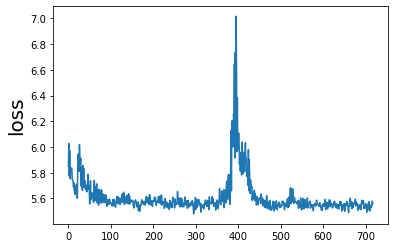

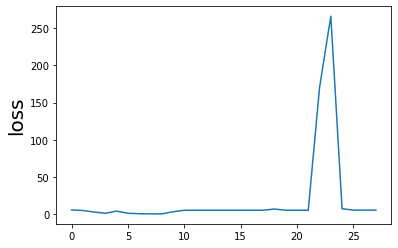

In [96]:
print('total epochs', model.epochs)
plot_loss(loss_train)
plot_loss(model.losses)

In [74]:
model_optimizer = AdamWarmup_dec(d_emb, warmup_steps, optimizer)

In [93]:
#model_optimizer.lr

In [90]:
model_optimizer = torch.optim.AdamW(model.parameters(), lr = 0.01, weight_decay=l2, amsgrad=False)

## Evaluate

In [67]:
flag_load = True

In [68]:
%run Transformer_class.ipynb
if flag_load:
    state = torch.load(my_path + 'tokenizer.pt')
    tokenizer = state['model'].to(device)

In [97]:
word_length = 32
answer_len = 64
while(1):
    question = input("You: ") 
    if question == 'quit':
        break
    question = get_data_from_line(tokenizer, question, words_tokenized, words_to_index, word_length, 
                                  token_map, rev_token_map, parallel = False)
    question = question.to(device).unsqueeze(0)
    reply = evaluate(model, question, answer_len, seq_length, token_map, rev_token_map)
    
    print(reply)

You:  state


, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , 


You:  only


, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , 


You:  hamlet?


, , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , 


You:  quit


# Works

In [47]:
criter = nn.KLDivLoss(reduction = 'none')
smooth = 0.1
confidence = 1.0 - smooth
size = vocab_size

In [49]:
x = torch.empty((4, 8), dtype = torch.long, device = device)
y = torch.empty((4, 8), dtype = torch.long, device = device)

file_name = np.random.choice(texts)
data = get_data_from_file(file_name, token_map, words_tokenized, words_to_index)
##
data_len = data.size(0) - 8 - 2
#order = np.random.permutation(np.arange(0, data_len, seq_length // frequency))
samples_amount = int(data_len / 8 * frequency)
order = np.random.choice(np.arange(data_len), size = samples_amount, replace = False)
or_length = order.shape[0]
loss_tempo = []
j = 0
for i, start_ind in enumerate(order):
    end_ind = start_ind + 8
    x[j] = data[start_ind : end_ind]
    y[j] = data[start_ind + 1 : end_ind + 1]
    j += 1
    if j % 4 == 0 or i == or_length - 1:
        break

In [50]:
print(x.size(), y.size())

torch.Size([4, 8]) torch.Size([4, 8])


In [51]:
out = model(x)

In [52]:
out.size()

torch.Size([4, 8, 14618])

In [53]:
prediction = rearrange(out, 'i j k -> (i j) k')   # (batch_size * seq_length, vocab_size)
target = rearrange(y, 'i j -> (i j)').contiguous()   # (batch_size * seq_length)
print(prediction.size(), target.size())

torch.Size([32, 14618]) torch.Size([32])


In [54]:
labels = torch.full(prediction.shape, smooth / (size - 1)).to(device)

In [55]:
labels.size()

torch.Size([32, 14618])

In [56]:
labels.scatter_(1, target.data.unsqueeze(1), confidence)
labels.size()

torch.Size([32, 14618])

tensor(1., device='cuda:0')

In [84]:
loss = criter(prediction, labels)

In [85]:
loss.size()

torch.Size([4096, 14618])

In [46]:
F.softmax(torch.Tensor([0, 1, 0, 0, 0, 0, 0]))

<ipython-input-46-2c23dc4b629f>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(torch.Tensor([0, 1, 0, 0, 0, 0, 0]))


tensor([0.1147, 0.3118, 0.1147, 0.1147, 0.1147, 0.1147, 0.1147])

In [37]:
labels = torch.full((4, 8), 0.1 / (8 - 1))

In [38]:
labels

tensor([[0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143],
        [0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143],
        [0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143],
        [0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143]])

In [4]:
torch.tril(torch.ones(4, 4))

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

In [5]:
torch.triu(torch.ones(4, 4)).transpose(0, 1)

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])

In [3]:
torch.triu_indices(4, 4, offset = 1)

tensor([[0, 0, 0, 1, 1, 2],
        [1, 2, 3, 2, 3, 3]])

In [283]:
texts = glob.glob(my_path + 'parts/*.txt')

In [284]:
char_to_num, num_to_char = create_char_dict()

In [299]:
word_length = 16
seq_length = 32
batch_size = 64
layers = [1, 8, 16, 32]
d_emb = 256
dropout = 0

In [291]:
file_name = random.choice(texts)
data = get_data_from_file(file_name, word_length, char_to_num)

In [293]:
#data_len = len(data) - batch_size - seq_length
x = []
y_input = []
y_target = []
for word in range(batch_size):
    start_ind = batch + word
    middle_ind = start_ind + seq_length
    end_ind = middle_ind + seq_length
    x.append(data[start_ind : middle_ind])
    y_input.append(data[middle_ind - 1 : end_ind - 1])
    y_target.append(data[middle_ind : end_ind])

In [295]:
x = torch.as_tensor(x)#.to(device)
y_input = torch.as_tensor(y_input)#.to(device)
y_target = torch.as_tensor(y_target)#.to(device)

In [332]:
#y_target[0]

In [306]:
embedd = Embedder(word_length, layers, d_emb, dropout, seq_length)

In [307]:
x_out = embedd(x.float())

In [308]:
x_out.shape

torch.Size([64, 32, 256])

In [6]:
np.random.permutation(10)

array([8, 0, 2, 6, 3, 4, 7, 9, 1, 5])

In [18]:
def opt_lr(epoch):
    return 0.004 * np.e**(-epoch/300)

In [19]:
opt_lr(1000)

0.00014269597338900962

In [34]:
arr = np.arange(1, 10001)

In [21]:
brr = opt_lr(arr)

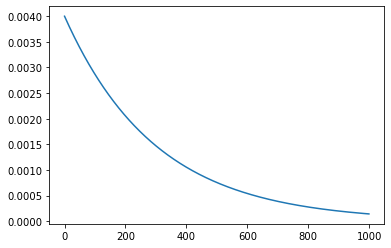

In [22]:
plt.plot(arr)
plt.show()

In [25]:
def lrupdate(x):
    return 256 ** (-0.5) * min(x ** (-0.5), x * 4000 ** (-1.5))

In [35]:
brr = np.empty(10000)

In [36]:
for i, a in enumerate(arr):
    brr[i] = lrupdate(a)

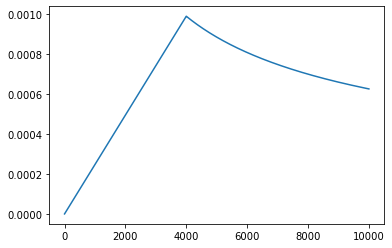

In [37]:
plt.plot(brr)
plt.show()

In [215]:
set_dropout(model, 0)

In [56]:
voc_s = 100
smooth = 0.1
confidence = 1 - smooth
criterion = nn.KLDivLoss(reduction = 'none')

In [ ]:
prediction = torch.rand(128, 32, voc_s)
target = torch.randint(10, (128, 32))
prediction = rearrange(prediction, 'i j k -> (i j) k')
target = rearrange(target, 'i j -> (i j)')
labels = torch.full(prediction.shape, smooth / (voc_s - 1))



# mask = mask.float()
# mask = mask.view(-1)       # (batch_size * max_words)
labels.scatter_(1, target.data.unsqueeze(1), self.confidence)

In [58]:
prediction = torch.rand(128, 32, voc_s)
type(prediction)

torch.Tensor

In [357]:
target = torch.randint(10, (128, 32))
target.shape

torch.Size([128, 32])

In [358]:
prediction = rearrange(prediction, 'i j k -> (i j) k')
prediction.shape

torch.Size([4096, 100])

In [359]:
target = rearrange(target, 'i j -> (i j)')
target.shape

torch.Size([4096])

In [360]:
labels = torch.full(prediction.shape, smooth / (voc_s - 1))
labels.shape

torch.Size([4096, 100])

In [361]:
labels.scatter_(1, target.unsqueeze(1), confidence)

tensor([[0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.9000, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        ...,
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010]])

In [371]:
loss = criterion(prediction, labels)

In [375]:
loss.sum(1)

tensor([-1.3567, -1.2366, -1.6016,  ..., -1.2049, -1.7134, -1.6225])

In [328]:
X_len

tensor([4, 1, 5, 3])

In [181]:
mask = torch.arange(maxlen)[None, :] < X_len[:, None]
mask

tensor([[ True,  True,  True,  True, False],
        [ True, False, False, False, False],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True, False, False]])

In [180]:
X_len[:, None]

tensor([[4],
        [1],
        [6],
        [3]])

In [182]:
X[~mask] = float('-inf')
X

tensor([[4.6000, 4.4000, 3.4000, 4.2000,   -inf],
        [4.4000,   -inf,   -inf,   -inf,   -inf],
        [3.2000, 4.2000, 5.0000, 4.0000, 3.6000],
        [3.6000, 3.4000, 4.2000,   -inf,   -inf]], dtype=torch.float64)

In [42]:
query = [1, 2]
key = [2, 4]
value = [3, 5]

In [113]:
torch.arange(0, 8, 2)

tensor([0, 2, 4, 6])

In [122]:
np.random.permutation([2, 5])

array([2, 5])

In [39]:
tens1 = torch.rand(2, 3, 4, 4)
tens2 = torch.randint(10, (4, 2, 3))

In [40]:
tens1

tensor([[[[0.7623, 0.8450, 0.3682, 0.6576],
          [0.9663, 0.5621, 0.8374, 0.5769],
          [0.4835, 0.0790, 0.6344, 0.3626],
          [0.4561, 0.6238, 0.3120, 0.8371]],

         [[0.8442, 0.6722, 0.8046, 0.3118],
          [0.2308, 0.3600, 0.2550, 0.9474],
          [0.5318, 0.6913, 0.8854, 0.1981],
          [0.0054, 0.0419, 0.0806, 0.0649]],

         [[0.8957, 0.9161, 0.2589, 0.9291],
          [0.7460, 0.7448, 0.5106, 0.8558],
          [0.8403, 0.6256, 0.7644, 0.7588],
          [0.9533, 0.5586, 0.2438, 0.8019]]],


        [[[0.7899, 0.5312, 0.0525, 0.2539],
          [0.3274, 0.7521, 0.6769, 0.0284],
          [0.4078, 0.1044, 0.9185, 0.6738],
          [0.5765, 0.8693, 0.8912, 0.5624]],

         [[0.3052, 0.7401, 0.5834, 0.4826],
          [0.7597, 0.4807, 0.9562, 0.4233],
          [0.3731, 0.7180, 0.8609, 0.5208],
          [0.4574, 0.6568, 0.1493, 0.1426]],

         [[0.9422, 0.5193, 0.8503, 0.7638],
          [0.5910, 0.5961, 0.5622, 0.4374],
          [0.4099, 0

In [41]:
d = tens1.size(-1)
d

4

In [42]:
inds = torch.triu_indices(d, d, offset = 1)

In [43]:
tens1[..., inds[0], inds[1]] = -float('inf')

In [44]:
tens1

tensor([[[[0.7623,   -inf,   -inf,   -inf],
          [0.9663, 0.5621,   -inf,   -inf],
          [0.4835, 0.0790, 0.6344,   -inf],
          [0.4561, 0.6238, 0.3120, 0.8371]],

         [[0.8442,   -inf,   -inf,   -inf],
          [0.2308, 0.3600,   -inf,   -inf],
          [0.5318, 0.6913, 0.8854,   -inf],
          [0.0054, 0.0419, 0.0806, 0.0649]],

         [[0.8957,   -inf,   -inf,   -inf],
          [0.7460, 0.7448,   -inf,   -inf],
          [0.8403, 0.6256, 0.7644,   -inf],
          [0.9533, 0.5586, 0.2438, 0.8019]]],


        [[[0.7899,   -inf,   -inf,   -inf],
          [0.3274, 0.7521,   -inf,   -inf],
          [0.4078, 0.1044, 0.9185,   -inf],
          [0.5765, 0.8693, 0.8912, 0.5624]],

         [[0.3052,   -inf,   -inf,   -inf],
          [0.7597, 0.4807,   -inf,   -inf],
          [0.3731, 0.7180, 0.8609,   -inf],
          [0.4574, 0.6568, 0.1493, 0.1426]],

         [[0.9422,   -inf,   -inf,   -inf],
          [0.5910, 0.5961,   -inf,   -inf],
          [0.4099, 0

In [ ]:
torch.einsum('...td,...id->...ti', tens1, tens2)

In [ ]:
rearrange(tens2, '... i j -> ... (i j)')

In [30]:
tens1.size(-1)

4

In [23]:
torch.triu_indices(5, 5, offset = 1)

tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4],
        [0, 1, 2, 3, 4, 1, 2, 3, 4, 2, 3, 4, 3, 4, 4]])

(4, 5, 3, 2)

In [37]:
tempo = torch.einsum('...ij->...ji', tens2)
tempo

tensor([[[7, 4],
         [6, 8],
         [6, 9]],

        [[6, 4],
         [5, 5],
         [3, 5]],

        [[4, 7],
         [1, 7],
         [3, 2]],

        [[3, 9],
         [5, 9],
         [6, 2]]])

In [39]:
torch.einsum('...ij,...jk->...ik', tens1, tempo)

tensor([[[ 86,  72],
         [136, 169]],

        [[ 91,  89],
         [ 75,  67]],

        [[ 66, 121],
         [ 46, 105]],

        [[ 66, 130],
         [ 78, 118]]])

In [40]:
torch.einsum('...ij,...kj->...ik', tens1, tens2)

tensor([[[ 86,  72],
         [136, 169]],

        [[ 91,  89],
         [ 75,  67]],

        [[ 66, 121],
         [ 46, 105]],

        [[ 66, 130],
         [ 78, 118]]])

# Old

In [9]:
class Conv1d_layer(nn.Module):
    def __init__(self, ch_in, ch_out, word_length, ker = 3, padding = 1):
        super().__init__()
        self.conv = nn.Conv1d(ch_in, ch_out, ker, padding = padding)
        self.ln = nn.LayerNorm(word_length)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.ln(x)
        x = F.relu(x)
        return x

In [10]:
class Embedder(nn.Module):
    def __init__(self, word_length, emb_layers, d_emb, emb_drop, seq_length):
        super().__init__()
        
        net = []
        for i in range(len(emb_layers) - 1):
            net.append(Conv1d_layer(emb_layers[i], emb_layers[i + 1], word_length))
        self.net = nn.Sequential(*net)
                
        self.out = nn.Linear(word_length * emb_layers[-1], d_emb)   
        
        self.d_emb = d_emb
        self.sr_d_emb = np.sqrt(d_emb)
        self.dropout = nn.Dropout(emb_drop)
        self.seq_length = seq_length
        self.pos_encode()
        
        self.net.apply(self.init_weights)
        
    def init_weights(self, m):
        if isinstance(m, nn.Conv1d):
            nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        
    def pos_encode(self):
        self.pe = torch.zeros(self.seq_length, self.d_emb)
        pos = torch.arange(0, self.seq_length)
        ii = torch.arange(0, self.d_emb, 2)
        div_term = torch.exp(ii * -np.log(10000) / self.d_emb)
        matrix = torch.einsum('i,j->ij', pos, div_term)
        self.pe[:, 0::2] = torch.sin(matrix)
        self.pe[:, 1::2] = torch.cos(matrix)
        self.pe = self.pe.unsqueeze(0)
        self.pe = self.pe.to(device)
    
    def forward(self, x):
        x = rearrange(x, 'b s (i j) -> (b s) i j', i = 1)
        # x = self.conv1(x)
        # x = self.ln1(x)
        # x = F.relu(x)
        # x = self.conv2(x)
        # x = self.ln2(x)
        # x = F.relu(x)
        # x = self.conv3(x)
        x = self.net(x)
        x = rearrange(x, '(b s) i j -> b s (i j)', s = self.seq_length)
        x = self.out(x)
        
        # make embeddings relatively larger
        x = x * self.sr_d_emb
        #add constant to embedding
        x = x + self.pe[:, :x.size(1)]
        x = self.dropout(x)
        return x

In [214]:
class CBOWModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOWModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size*embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
        
    def forward(self, x):
        embeds = self.embeddings(x).view(1,-1)
        output = self.linear1(embeds)
        output = F.relu(output)
        output = self.linear2(output)
        log_probs = F.log_softmax(output, dim=1)
        return log_probs

In [11]:
# def create_masks(question, reply_input, reply_target):
    
#     def subsequent_mask(size):
#         mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
#         return mask.unsqueeze(0)
    
#     question_mask = question!=0
#     question_mask = question_mask.to(device)
#     question_mask = question_mask.unsqueeze(1).unsqueeze(1)         # (batch_size, 1, 1, max_words)
     
#     reply_input_mask = reply_input!=0
#     reply_input_mask = reply_input_mask.unsqueeze(1)  # (batch_size, 1, max_words)
#     reply_input_mask = reply_input_mask & subsequent_mask(reply_input.size(-1)).type_as(reply_input_mask.data) 
#     reply_input_mask = reply_input_mask.unsqueeze(1) # (batch_size, 1, max_words, max_words)
#     reply_target_mask = reply_target!=0              # (batch_size, max_words)
    
#     return question_mask, reply_input_mask, reply_target_mask

In [19]:
class Decoder(nn.Module):
    def __init__(self, d_emb, hidden_mult, order, dec_drop):
        super().__init__()
        layers = []
        for heads in heads_order:
            layers.append(Decoder_layer(dec_drop, hidden_mult, d_emb, hidden_dim, heads))
        self.layers = nn.Sequential(*layers)
                
    def forward(self, x):
        x = self.layers(x)
        return x

In [5]:
def create_char_dict():
    i = 0
    char_to_num = {}
    num_to_char = {}
    for c in range(48,58):
        i += 1
        num = (i + 4) / 44
        char = chr(c)
        char_to_num[char] = num
        num_to_char[num] = char
    for c in range(97, 123):
        i += 1
        num = (i + 4) / 44
        char = chr(c)
        char_to_num[char] = num
        num_to_char[i] = char
    return char_to_num, num_to_char

def nums_to_word(word, num_to_char):
    word_out = ''
    for w in word:
        letter = round(w * 44 - 4)
        word_out += num_to_char.get(letter, '')
    return word_out

In [6]:
def remove_punc(line):
    pattern = re.compile('[^a-zA-Z0-9 ]+') 
    no_punct = pattern.sub('', line.strip())
    return no_punct.lower()

def get_data_from_file(file_name, word_length, char_to_num):
    words = []
    with open(file_name, 'r') as f:
        for line in f:
            l = remove_punc(line)
            words.extend(l.split())
    data = []
    it = iter(words)
    while True:
        try:
            word = next(it)
        except StopIteration:
            break
        w = np.zeros(word_length)
        for i, char in enumerate(word[:word_length]):
            w[i] = char_to_num[char]
        data.append(w)
    return np.asarray(data)

def get_data_from_line(line, word_length, char_to_num):
    words = remove_punc(line).split()
    data = []
    it = iter(words)
    while True:
        try:
            word = next(it)
        except StopIteration:
            break
        w = np.zeros(word_length)
        for i, char in enumerate(word[:word_length]):
            w[i] = char_to_num[char]
        data.append(w)
    return np.asarray(data)

def data_to_line(line, num_to_char):
    line_out = ''
    for word in line:
        word_out = nums_to_word(word, num_to_char)
        line_out = line_out + word_out + ' '
    return line_out

In [7]:
def encode_question(words, word_map, max_len):
    enc_c = [word_map.get(word, word_map['<unk>']) for word in words] \
            + [word_map['<pad>']] * (max_len - len(words))
    return enc_c

def encode_reply(words, word_map, max_len):
    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words] \
            + [word_map['<end>']] + [word_map['<pad>']] * (max_len - len(words) - 1)
    # enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words] \
    #         + [word_map['<end>']] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c

In [8]:
def set_dropout(model, drop_rate):
    for name, child in model.named_children():
        if isinstance(child, torch.nn.Dropout):
            child.p = drop_rate
        set_dropout(child, drop_rate = drop_rate)

In [9]:
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel('epochs', fontsize=20)
    plt.ylabel('loss', fontsize=20)
    plt.show()